# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。

## モジュールと関数の用意

In [1]:
from datetime import datetime
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd

%matplotlib inline

In [2]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2=None):
    """find_cross_points(y1, y2=None) -> numpy.1darray
    find cross points between two data sequences
    If y2 == None, then find the root of y1.
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if y2 is None:
        y2 = np.zeros_like(y1)
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

In [14]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["close"] - dataFrame["open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [4]:
def peakdet(v, delta, x=None):
    """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
        Returns two np.arrays
        function [maxtab, mintab]=peakdet(v, delta, x)
        % PEAKDET Detect peaks in a vector
        % [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        % maxima and minima ("peaks") in the vector V.
        % MAXTAB and MINTAB consists of two columns. Column 1
        % contains indices in V, and column 2 the found values.
        %
        % With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        % in MAXTAB and MINTAB are replaced with the corresponding
        % X-values.
        %
        % A point is considered a maximum peak if it has the maximal
        % value, and was preceded (to the left) by a value lower by
        % DELTA.
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
        v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

## データの読み込み

In [6]:
df = pd.read_csv("../data/OHLCV_201812241200_to_201812311200.csv", index_col=0)
df.head()

,time,close,high,low,open,volumefrom,volumeto
0,2018-12-24T15:42:00.000000,467026,467090,466514,466699,228.61,1.067154e+08
1,2018-12-24T15:43:00.000000,467035,467400,466793,467026,383.26,1.790210e+08
2,2018-12-24T15:44:00.000000,466853,467045,466569,467035,229.46,1.071007e+08
3,2018-12-24T15:45:00.000000,466945,467021,466702,466853,192.55,8.989532e+07
4,2018-12-24T15:46:00.000000,467122,467346,466943,466945,303.19,1.416186e+08


In [7]:
df.tail()

,time,close,high,low,open,volumefrom,volumeto
9854,2018-12-31T11:56:00.000000,416478,417499,415800,417115,1175.35,4.896480e+08
9855,2018-12-31T11:57:00.000000,417646,417827,416000,416478,1025.69,4.275353e+08
9856,2018-12-31T11:58:00.000000,417111,417646,416978,417646,549.11,2.291352e+08
9857,2018-12-31T11:59:00.000000,417143,417211,416800,417111,331.31,1.381525e+08
9858,2018-12-31T12:00:00.000000,417162,417258,416592,417143,417.24,1.739657e+08


７月半ばから１１月半ばの４か月と一週間分のデータを対象とする。

## 前回の分析の最後

In [9]:
N1 = 5; N2 = 20;
ema1 = calc_EMA(df["close"].values, N1)
ema2 = calc_EMA(df["close"].values, N2)

In [10]:
columns = ["time", "open", "high", "low", "close"]

df_ = df.copy()
tuples = [tuple(x) for x in df_[columns].values]
x = df_["time"].values
cross_points = find_cross_points(ema1, ema2)

In [11]:
ind_ = cross_points != 0
a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
a_k

array([[   2,   -1],
       [   5,    1],
       [  10,   -1],
       ...,
       [9738,   -1],
       [9805,    1],
       [9814,   -1]])

In [37]:
close_ = df["close"]
open_ = df["open"]

N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
    dec_ext[ii] = dec[ind1]

(-10000, 10000)

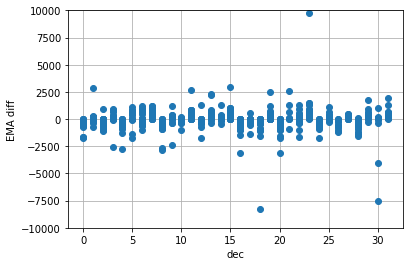

In [16]:
plt.plot(dec_ext, ema_diff_ext, "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.grid(True)
plt.ylim(-10000, 10000)

データを見直したら、実は多少は特徴が出ている模様。

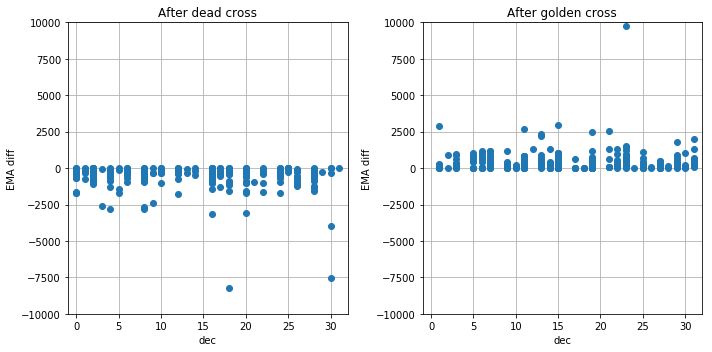

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], ema_diff_ext[::2], "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 10000)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], ema_diff_ext[1::2], "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 10000)
plt.grid(True)

plt.tight_layout()

特定のパターンでは一方向にのみ値が出ている。   
パターンがないまたはパターンがあってもdiffが小さいものは、   
そのパターンからの発展が弱いということを意味する。   

In [38]:
histo_dead, x_bin = np.histogram(dec_ext[::2], bins=np.arange(2**N_dec+1))
histo_golden, x_bin = np.histogram(dec_ext[1::2], bins=np.arange(2**N_dec+1))

histo_diff = histo_golden - histo_dead

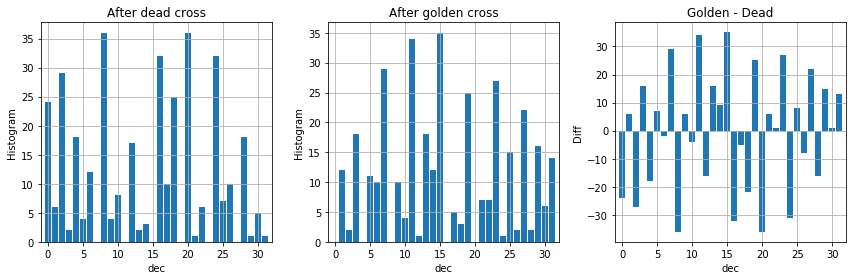

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.bar(x_bin[:-1], histo_dead)
plt.xlabel("dec")
plt.ylabel("Histogram")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.grid(True)

plt.subplot(132)
plt.bar(x_bin[:-1], histo_golden)
plt.xlabel("dec")
plt.ylabel("Histogram")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.grid(True)

plt.subplot(133)
plt.bar(x_bin[:-1], histo_diff)
plt.xlabel("dec")
plt.ylabel("Diff")
plt.title("Golden - Dead")
plt.xlim(-1, 2**N_dec)
plt.grid(True)

plt.tight_layout()

In [39]:
bin_golden = []
bin_dead = []

threshold = 0.8

for ii in range(2**N_dec):
    if histo_diff[ii] > 0 and histo_diff[ii]/(histo_golden[ii]+histo_dead[ii]) > threshold:
        bin_golden.append("{0:05d}".format(int(format(ii, "b"))))
    elif histo_diff[ii] < 0 and histo_diff[ii]/(histo_golden[ii]+histo_dead[ii]) < -threshold:
        bin_dead.append("{0:05d}".format(int(format(ii, "b"))))

In [40]:
bin_golden, bin_dead, len(bin_golden), len(bin_dead)

(['00111', '01011', '01111', '10011', '10111', '11011', '11101', '11111'],
 ['00000', '00010', '00100', '01000', '01100', '10000', '10100', '11000'],
 8,
 8)

これらのパターンは、勝ち確定のパターンではなく、golden cross/dead crossの前に現れやすいパターンを示している。   
このパターンがあれば必ず後にgolden cross/dead crossが続くということを示しているのではなく、   
cross pointが現れたときにその前にこれらのパターンがあると、その後に安定してトレンドが発達する可能性があるということを意味する。

# 利確のパターン
Cross pointの前に現れやすいパターンがあるといっても、   
それで利確になるタイミングがつかめるかどうかを知るにはもう少し解析を進める必要がある。   
Cross pointの次のタイミングで入ったとして、その後の対のcrossに入るまでにEMAの差の最大・最小が現れるタイミングでのltpの差分と、   
これらのパターンの間に相関があるかどうかを検討する。

## 値の取り出し

In [42]:
N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)
open_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
        tm_ext[ii] = max(o_.values[tm], c_.values[tm])
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
        tm_ext[ii] = min(o_.values[tm], c_.values[tm])
    dec_ext[ii] = dec[ind1]
    
    if len(o_) > 1:
        open_ext[ii] = o_.values[1]
    else:
        open_ext[ii] = o_.values[0]
#     tm_ext[ii] = min(o_.values[tm], c_.values[tm])

benefits = tm_ext - open_ext
benefits[np.abs(benefits)>1e5] = 0.0
ema_diff_ext[np.abs(ema_diff_ext)>1e5] = 0.0

## 散布図

(-50000, 50000)

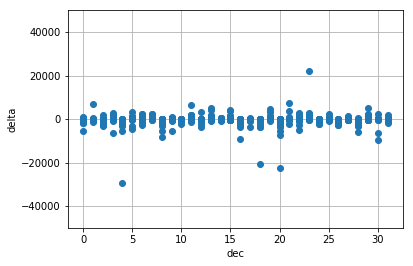

In [25]:
plt.figure()
plt.plot(dec_ext, benefits, "o")
plt.xlabel("dec")
plt.ylabel("delta")
plt.grid(True)
plt.ylim(-50000, 50000)

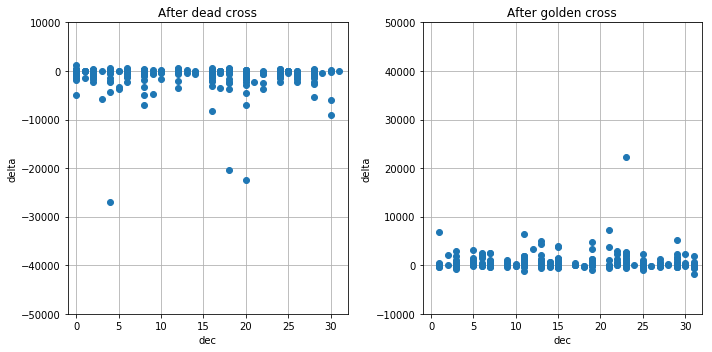

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], benefits[::2], "o")
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-50000, 10000)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], benefits[1::2], "o")
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 50000)
plt.grid(True)

plt.tight_layout()

わりとがっつりと利益が出そうな気がするが、、   
それぞれの場合で平均と分散、中央値を出してみる。

## 平均と分散

In [27]:
stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = benefits[::2][ii]
    list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

for ii in range(len(list_ext_dead)):
    arr = list_ext_dead[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_dead[ii] = arr[ind]
        stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = benefits[1::2][ii]
    list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

for ii in range(len(list_ext_golden)):
    arr = list_ext_golden[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_golden[ii] = arr[ind]
        stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

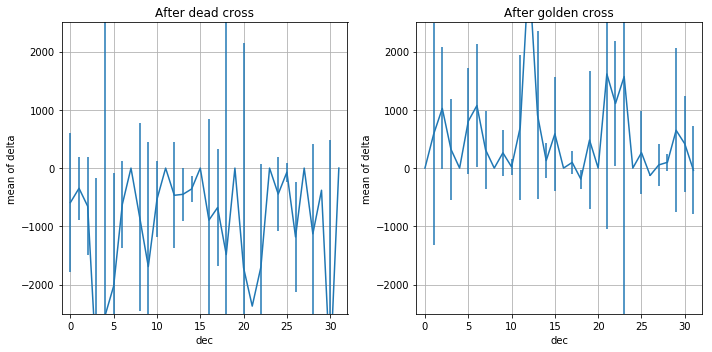

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

平均的には、dead crossの後は1000程度、golden crossの後は500~1000程度の差分が見込まれる。

## 箱ひげ図
平均と分散は有用ではあるのだが、外れ値がいるとどうしても幅が広いという印象を与えがちである。   
そのようなときは箱ひげ図が使える。

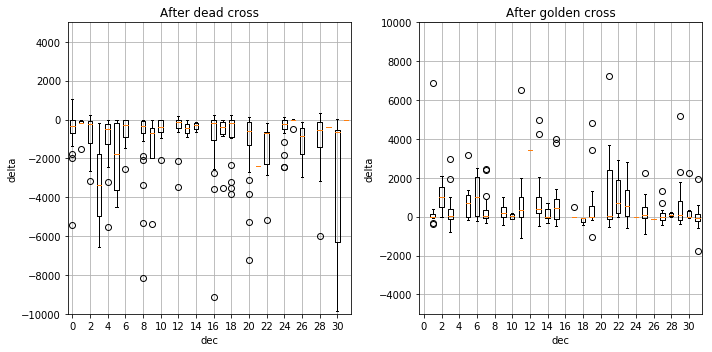

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## 仮にすべてのcross points で理想的なエントリー・約定を行えた場合の利益は？
1 BTCを購入したとする。

In [44]:
print(-benefits[::2].sum(), benefits[1::2].sum())
print(-benefits[::2].sum() + benefits[1::2].sum())

280644 202905
483549


1 BTC で購入していたと仮定すると、うまくいけば１週間で４８万稼げていたことになる。   

## EMAの差が最大・最小になった直後に約定するとどうなるか

In [45]:
N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)
open_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
        if tm != len(o_) - 1:
            tm_ext[ii] = max(o_.values[tm+1], c_.values[tm+1])
        else:
            tm_ext[ii] = max(o_.values[tm], c_.values[tm])
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
        if tm != len(o_) - 1:
            tm_ext[ii] = min(o_.values[tm+1], c_.values[tm+1])
        else:
            tm_ext[ii] = min(o_.values[tm], c_.values[tm])
    dec_ext[ii] = dec[ind1]
    
    if len(o_) > 1:
        open_ext[ii] = o_.values[1]
    else:
        open_ext[ii] = o_.values[0]
#     if tm != len(o_) - 1:
#         tm_ext[ii] = min(o_.values[tm+1], c_.values[tm+1])
#     else:
#         tm_ext[ii] = min(o_.values[tm], c_.values[tm])

benefits = tm_ext - open_ext
benefits[np.abs(benefits)>1e5] = 0.0
ema_diff_ext[np.abs(ema_diff_ext)>1e5] = 0.0

In [32]:
stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = benefits[::2][ii]
    list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

for ii in range(len(list_ext_dead)):
    arr = list_ext_dead[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_dead[ii] = arr[ind]
        stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = benefits[1::2][ii]
    list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

for ii in range(len(list_ext_golden)):
    arr = list_ext_golden[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_golden[ii] = arr[ind]
        stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

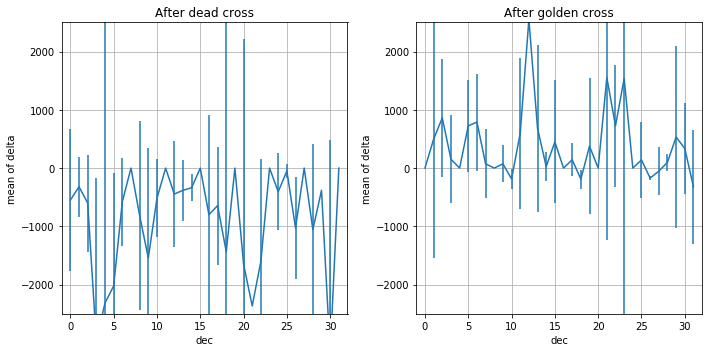

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

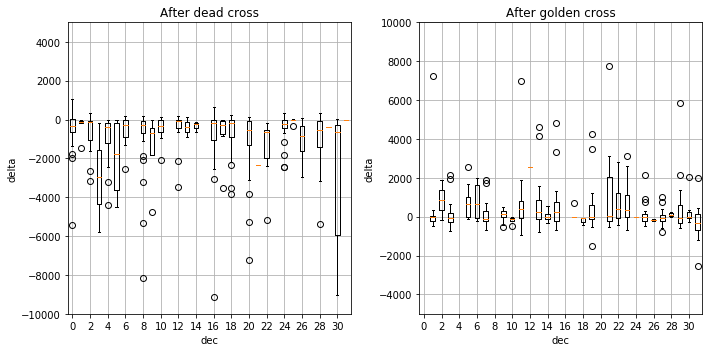

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

### 仮にすべてのcross points で理想的なエントリー・約定を行えた場合の利益は？
1 BTCを購入したとする。

In [46]:
print(-benefits[::2].sum(), benefits[1::2].sum())

200082 153587


それでも１週間で３５万。

## EMA1-EMA2との相関

Cov: [[1.         0.93973588]
 [0.93973588 1.        ]]


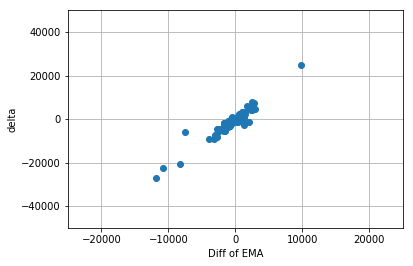

In [36]:
plt.figure()
plt.plot(ema_diff_ext, benefits, "o")
plt.xlabel("Diff of EMA")
plt.ylabel("delta")
plt.grid(True)
plt.ylim(-50000, 50000)
plt.xlim(-25000, 25000)
print("Cov:", np.corrcoef(ema_diff_ext, benefits))

EMA1-EMA2の最大・最小とdeltaの間には明瞭な相関がある（当たり前か）。   
外れるようなものがあれば、それはそれで興味深かっただろうが。

## まとめ
* パターンの現れ方および約定時の利益の見積もりを比較すると、これらは2018年7月～2018年11月のデータの解析結果と2018年最終週のデータで同等の結果であった。つまり過去５か月についてはスケーラビリティが存在するといってよさそうである。

# もう少し現実的な利益の最小値の期待値の見積もり
前節の解析よりもう少し現実的にみる。前節ではbenefitの定義として、   
benefit＝（頂点の一つ後のopen、closeのうちEMA2と距離が近いほう）－（cross pointの位置の直後のopenの値）   
としていた。上式の第二項を"（cross pointの位置の直後のopen、closeのうちEMA2と距離が遠いほう）"とすることで、   
利益の最小値の期待値を定義する。   
（※high/low は期待値にかかわらないという強引な仮定を置いているが、それほどわるくないはず。）

In [47]:
N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)
t1_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0:
        if len(o_) > 1:
            t1_ext[ii] = min(o_.values[1], c_.values[1])
        else:
            t1_ext[ii] = min(o_.values[0], c_.values[0])
        
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
        if tm != len(o_) - 1:
            tm_ext[ii] = max(o_.values[tm+1], c_.values[tm+1])
        else:
            tm_ext[ii] = max(o_.values[tm], c_.values[tm])
    else:
        if len(o_) > 1:
            t1_ext[ii] = max(o_.values[1], c_.values[1])
        else:
            t1_ext[ii] = max(o_.values[0], c_.values[0])
        
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
        if tm != len(o_) - 1:
            tm_ext[ii] = min(o_.values[tm+1], c_.values[tm+1])
        else:
            tm_ext[ii] = min(o_.values[tm], c_.values[tm])
    dec_ext[ii] = dec[ind1]

benefits = tm_ext - t1_ext
benefits[np.abs(benefits)>1e5] = 0.0
ema_diff_ext[np.abs(ema_diff_ext)>1e5] = 0.0

In [48]:
stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = benefits[::2][ii]
    list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

for ii in range(len(list_ext_dead)):
    arr = list_ext_dead[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_dead[ii] = arr[ind]
        stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = benefits[1::2][ii]
    list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

for ii in range(len(list_ext_golden)):
    arr = list_ext_golden[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_golden[ii] = arr[ind]
        stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

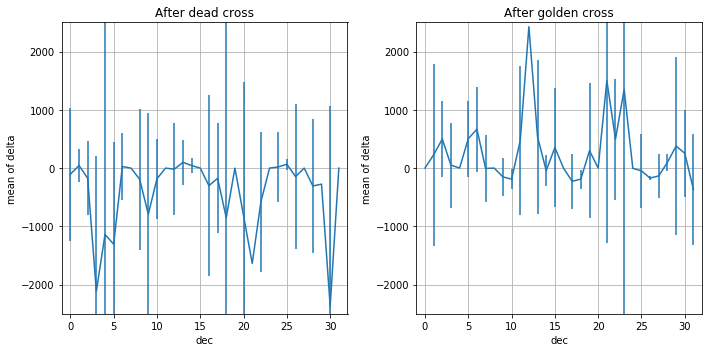

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

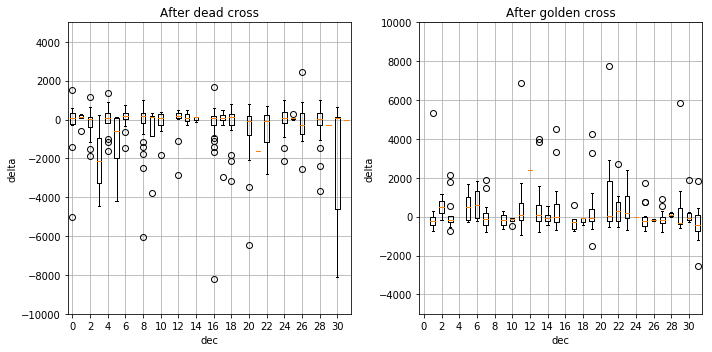

In [50]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

### 仮にすべてのcross points で理想的なエントリー・約定を行えた場合の利益は？
1 BTCを購入したとする。

In [52]:
print(-benefits[::2].sum(), benefits[1::2].sum())

133756 109199


箱ひげ図を見る限り、期待値が望めそうなパターンはいくつかあるものの、それ以外は平均的にも利益の最小値はマイナスになる様子。   
また、すべてのエントリーが理想的であったとしたときの利益の最小値はの期待値は２４万/１BTCとなる。   

# 一つ目の山を越えたときに利確した場合
前のノートでも確認したが、最大値となるタイミングとパターンの間には明確な相関がみられない。   
つまり今てもとにある情報だけでは、最大値を与えるタイミングが分からないということである。   
この場合、利益を得られる約定タイミングとしては最初の山を越えたときとなる。   
今回はこのような状況での利益の最小値の期待値を確認する。   

※bitflyerFXでは手数料が０％。

## ピーク値の取得

In [54]:
maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
# maxtab_ema_diff = maxtab_ema_diff.astype(int)
# mintab_ema_diff = mintab_ema_diff.astype(int)

## ピーク位置のプロット

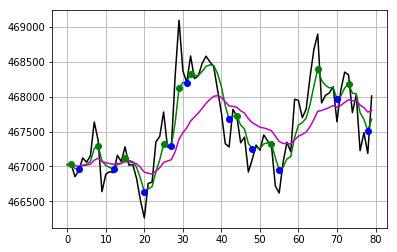

In [84]:
start = 0
end = 80
plt.plot(close_[start:end], "k")
plt.plot(ema1[start:end], "g")
plt.plot(ema2[start:end], "m")

# index = (maxtab0[:, 0]>=start)&(maxtab0[:, 0]<end)
# plt.plot(maxtab0[index, 0], maxtab0[index, 1], "bo")
# index = (mintab0[:, 0]>=start)&(mintab0[:, 0]<end)
# plt.plot(mintab0[index, 0], mintab0[index, 1], "ro")

index = (maxtab_ema_diff[:, 0]>=start)&(maxtab_ema_diff[:, 0]<end)
plt.plot(maxtab_ema_diff[index, 0], ema1[maxtab_ema_diff[index, 0].astype(int)], "go")
index = (mintab_ema_diff[:, 0]>=start)&(mintab_ema_diff[:, 0]<end)
plt.plot(mintab_ema_diff[index, 0], ema1[mintab_ema_diff[index, 0].astype(int)], "bo")

plt.grid(True)

## 演算

In [86]:
N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
dec_ext = np.zeros(len(a_k), int)
t1_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)
distance_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0: # dead cross
        # start value
        if len(o_) > 1:
            t1_ext[ii] = min(o_.values[1], c_.values[1])
        else:
            t1_ext[ii] = min(o_.values[0], c_.values[0])
        
        # minimum index
        index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            tm = (mintab_ema_diff[index, 0]).astype(int)[0]
        else:
#             tm = ind1 + 1
            tm = ind1
#         tm_ext[ii] = max(open_.values[tm], close_.values[tm])
        tm_ext[ii] = max(open_.values[tm+1], close_.values[tm+1])
        
    else: # golden cross
        # start value
        if len(o_) > 1:
            t1_ext[ii] = max(o_.values[1], c_.values[1])
        else:
            t1_ext[ii] = max(o_.values[0], c_.values[0])
        
        # maximum index
        index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
        else:
#             tm = ind1 + 1
            tm = ind1
#         tm_ext[ii] = min(open_.values[tm], close_.values[tm])
        tm_ext[ii] = min(open_.values[tm+1], close_.values[tm+1])
    distance_ext[ii] = tm - ind1 + 1
    
    dec_ext[ii] = dec[ind1]

benefits = tm_ext - t1_ext
benefits[np.abs(benefits)>1e5] = 0.0

In [77]:
stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = benefits[::2][ii]
    list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

for ii in range(len(list_ext_dead)):
    arr = list_ext_dead[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_dead[ii] = arr[ind]
        stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = benefits[1::2][ii]
    list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

for ii in range(len(list_ext_golden)):
    arr = list_ext_golden[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_golden[ii] = arr[ind]
        stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

## 平均値のプロット

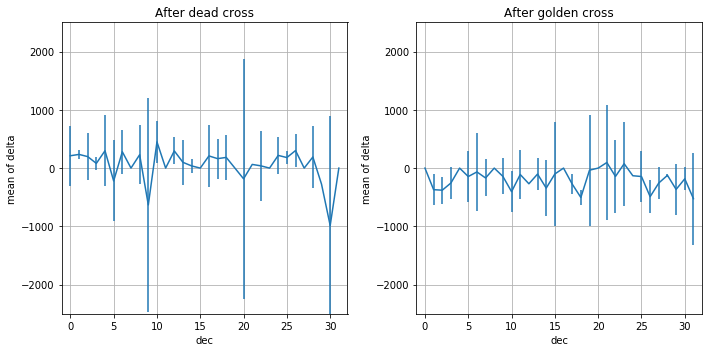

In [78]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

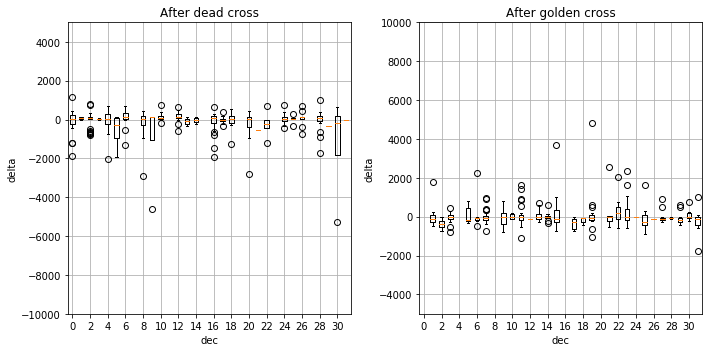

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

### 仮にすべてのcross points で理想的なエントリー・約定を行えた場合の利益は？
1 BTCを購入したとする。

In [79]:
print(-benefits[::2].sum(), benefits[1::2].sum())

-50917 -58987


最初の山で約定すると儲けが出ない。

### 最初の最大値の位置で約定を行えた場合
※直下のセルは実行済みのため、再実行してはいけない。

In [75]:
print(-benefits[::2].sum(), benefits[1::2].sum())

40167 9111


## 逆張りした場合
逆張りの場合、利益の最小値の計算で取得すべきmin,maxを逆転させる必要がある。

In [87]:
N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
dec_ext = np.zeros(len(a_k), int)
t1_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)
distance_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0: # dead cross
        # start value
        if len(o_) > 1:
            t1_ext[ii] = max(o_.values[1], c_.values[1])
        else:
            t1_ext[ii] = max(o_.values[0], c_.values[0])
        
        # minimum index
        index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            tm = (mintab_ema_diff[index, 0]).astype(int)[0]
        else:
#             tm = ind1 + 1
            tm = ind1
#         tm_ext[ii] = max(open_.values[tm], close_.values[tm])
        tm_ext[ii] = min(open_.values[tm+1], close_.values[tm+1])
        
    else: # golden cross
        # start value
        if len(o_) > 1:
            t1_ext[ii] = min(o_.values[1], c_.values[1])
        else:
            t1_ext[ii] = min(o_.values[0], c_.values[0])
        
        # maximum index
        index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
        else:
#             tm = ind1 + 1
            tm = ind1
#         tm_ext[ii] = min(open_.values[tm], close_.values[tm])
        tm_ext[ii] = max(open_.values[tm+1], close_.values[tm+1])
    distance_ext[ii] = tm - ind1 + 1
    
    dec_ext[ii] = dec[ind1]

benefits_inv = tm_ext - t1_ext
benefits_inv[np.abs(benefits)>1e5] = 0.0

In [89]:
print(benefits_inv[::2].sum(), -benefits_inv[1::2].sum())

-183104 -141664


逆張りだと確実に利益が出ない。

# まとめ
* 最初の山の直後で約定した場合、まず利益が出なさそうである。
* 逆張りだと利益の最小値が確実にマイナスになる。
* したがって別のスキームを立てる必要がある。
    + たとえばVolumeなどほかの情報を含めて確実に最大値をとる山を狙う、など。